### More Metric Subset Analysis

Specifically how does the correlation and regret change as a function of number of images per class in the datasets. To compute the representation I'll need to know the max number of classes and images for each dataset, I think that Phil's code keeps the proportions the same for smaller sizes?

N.B. The other metric subset notebook was getting messy so working here now.

In [2]:
import analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
import wandb
import yaml
from constants import DATASET_NAMES, MAX_SIZES

In [3]:
# Load the data
api = wandb.Api()
datasets = list(MAX_SIZES.keys())
train_data = utils.get_data(api, "train", datasets)
metric_data = utils.get_data(api, "metrics", datasets)
data = metric_data.merge(train_data, on=["dataset_name", "model_name", "n_samples"])

# Read in imagenet validation accuracies
with open("../configs/scores_imagenet1k.yaml") as f:
    imagenet = yaml.safe_load(f)
imagenet = [
    {"model_name": key, "imagenet-validation": {"score": imagenet[key]}}
    for key in imagenet.keys()
]
imagenet = pd.DataFrame(imagenet)

# Merge in imagenet val acc
data = data.merge(imagenet, on="model_name")

# Multiply test accuracy by 100 for regret computation
data["test_accuracy"] = data["test_accuracy"] * 100

In [5]:
# Compute all correlations accross different dataset sizes
group_data = data.groupby(["dataset_name", "n_samples", "n_metric_samples"])
metrics = ["renggli", "LogME", "n_pars", "imagenet-validation"]
corr_tables = []
for met in metrics:
    corr_tables.append(analysis.get_correlations(group_data, met))

# Compute all regrets across different dataset sizes
regret_tables = []
for met in metrics:
    regret_tables.append(analysis.get_regrets(group_data, met, 1))

In [6]:
DATASET_NAMES

{'huggan/wikiart': 'WikiArt',
 '/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMoSeT/binary_datasets/bin_tree': 'VG Tree',
 'pcuenq/oxford-pets': 'Oxford Pets',
 '/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMoSeT/binary_datasets/bin_faucet': 'VG Faucet',
 '/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMoSeT/binary_datasets/bin_watch': 'VG Watch',
 'aharley/rvl_cdip': 'RVL-CDIP'}

In [12]:
dataset_class_reps = {
    "WikiArt": 129,
    "VG Tree": 2,
    "Oxford Pets": 37,
    "VG Faucet": 2,
    "VG Watch": 2,
    "RVL-CDIP": 16,
}

In [13]:
metric_names = {
    "renggli": "Renggli",
    "LogME": "LogME",
    "n_pars": "N. Params",
    "imagenet-validation": "ImageNet Acc.",
}

In [14]:
def scale_samples_by_classes(samples, dataset):
    return samples / dataset_class_reps[dataset]

In [46]:
# Plot a single metric


def plot_metric_result(
    ax,
    metric_result,
    metric,
    error_bars=False,
    xscale="log",
    ylim=(0.0, 1.0),
    result_type="corr",
):
    """Plot the correlation per result for a single metric, in a single axis, for each
    dataset

    Args:
        ax: plt.ax from subplots on which to plot
        metric_result: dataframe of metric results
        metric: which metric is being looked at
        error_bars: plot error bars, default False
    """
    for dataset_name in DATASET_NAMES.values():
        dataset_result = metric_result[metric_result["dataset"] == dataset_name]
        # print(dataset_name)
        n_samples = scale_samples_by_classes(
            dataset_result["n_samples"].values, dataset_name
        )
        # print(dataset_name, n_samples)
        # print(n_samples)
        if result_type == "corr":
            met_vals = [v[0] for v in dataset_result[metric].values]
        elif result_type == "regret":
            met_vals = dataset_result[metric].values
        # print(corrs)
        err = None
        if error_bars:
            err = np.asarray(
                [
                    [v[0] - v[1][0], v[1][1] - v[0]]
                    for v in dataset_result[metric].values
                ]
            ).T
        ax.errorbar(n_samples, met_vals, yerr=err, label=dataset_name, marker="o")
        # ax.scatter(n_samples, corrs, label=dataset_name)
    ax.set_title(metric_names[metric], fontsize=15)
    ax.set_xlabel("Images Per Class", fontsize=12)
    if result_type == "corr":
        ax.set_ylabel("Correlation", fontsize=12)
    else:
        ax.set_ylabel("Regret", fontsize=12)
    ax.set_xscale(xscale)
    if metric == "renggli":
        ax.set_ylim(-0.2, ylim[1])
    else:
        ax.set_ylim(ylim[0], ylim[1])

In [47]:
# Function for all plots


def plot_all_metric_results(
    metric_results,
    metrics,
    error_bars=False,
    fig_size=(40, 10),
    xscale="log",
    ylim=(-0.2, 1.0),
    result_type="corr",
):
    """Plot all of the correlation results varying by dataset size on a single multiplot

    Args:
        metric_results: _description_
        metrics: _description_
        error_bars: _description_. Defaults to False.
    """
    fig, ax = plt.subplots(1, 4, figsize=fig_size)
    for idx, metric in enumerate(metrics):
        metric_result = metric_results[idx][
            metric_results[idx]["n_samples"] == metric_results[idx]["n_metric_samples"]
        ]
        plot_metric_result(
            ax[idx], metric_result, metric, error_bars, xscale, ylim, result_type
        )
    if result_type == "corr":
        fig.suptitle("Metric Correlations vs. Class Representation", fontsize="20")
    else:
        fig.suptitle("Metric Regret vs. Class Representation", fontsize="20")
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=15)

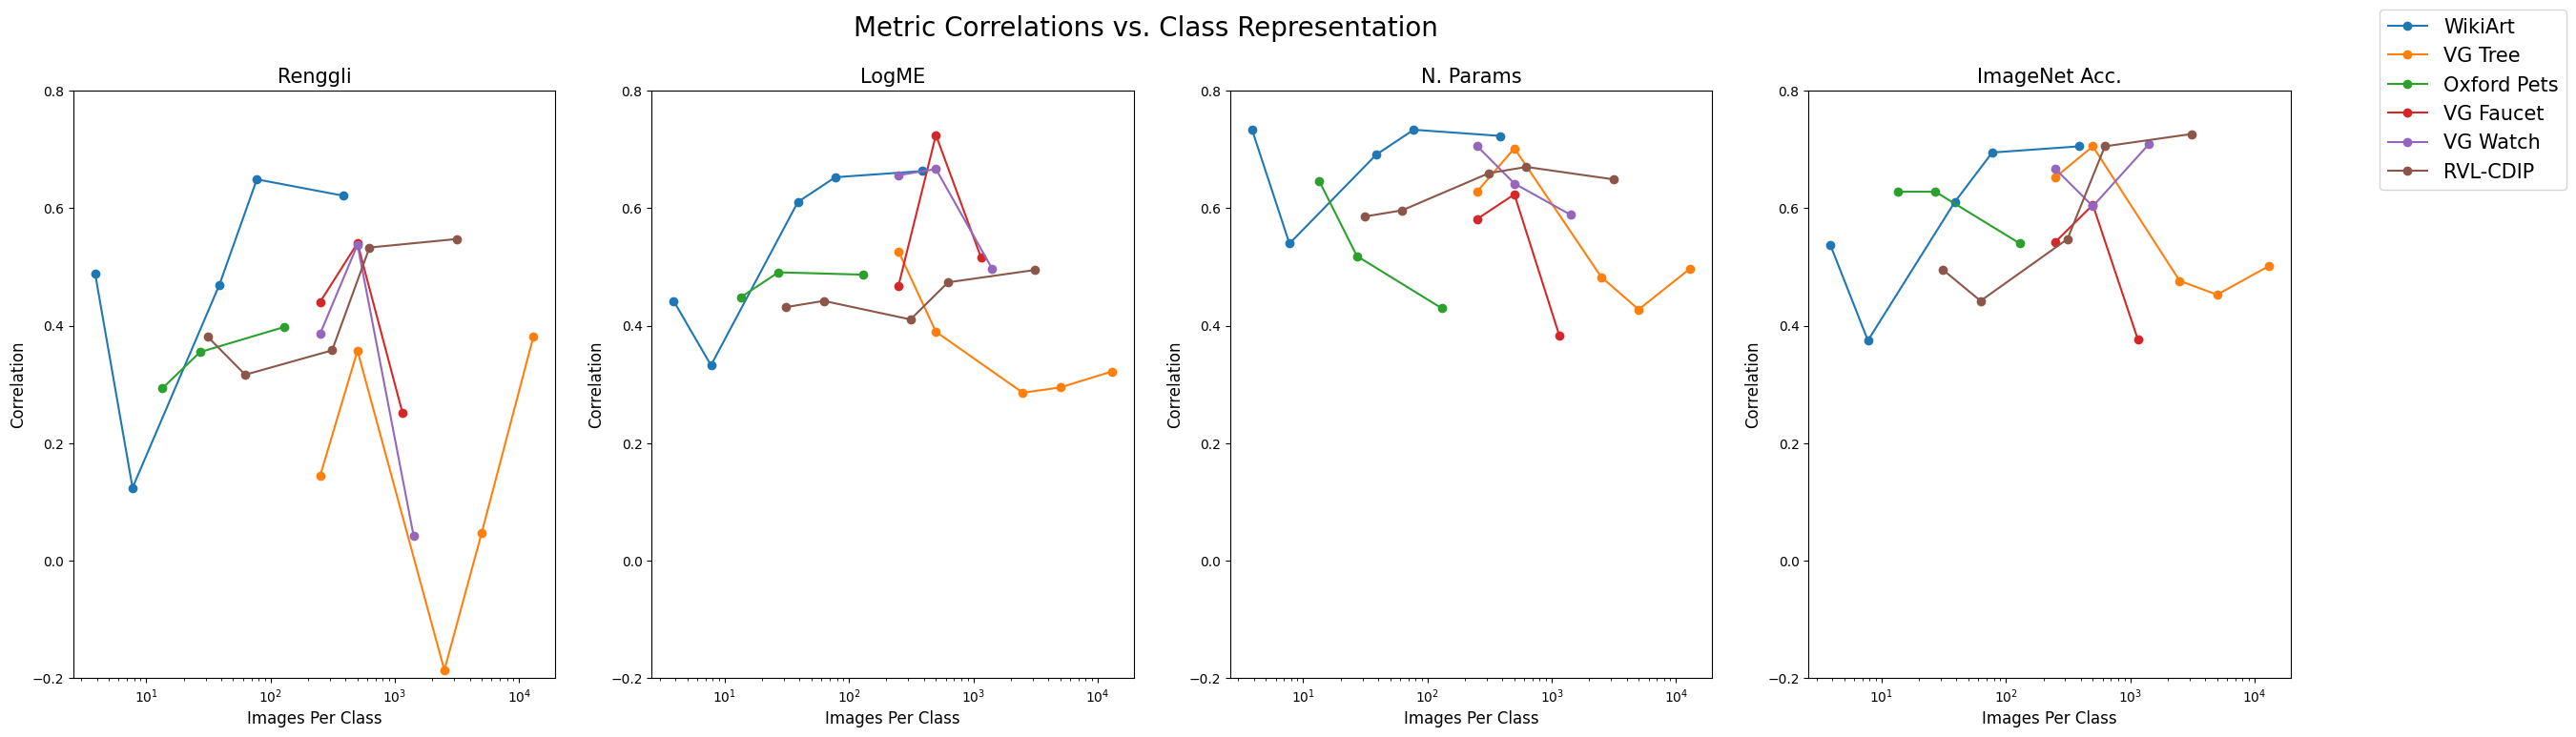

In [55]:
plot_all_metric_results(
    corr_tables,
    metric_names.keys(),
    error_bars=False,
    xscale="log",
    ylim=(-0.2, 0.8),
    fig_size=(30, 8),
    result_type="corr",
)